In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn==1.2.2


# This is to disable annoying warning messages from sklearn 1.2.2
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Assignment 4
## Ziad Arafat

### Reading in the data

1. We read in the CSV using the pandas library and store it in a dataframe. 
2. We print the data in the first two rows using the `head()` method

In [3]:
df_crop_recommend = pd.read_csv("Crop_Recommendation.csv")
print(df_crop_recommend.head(n=5))

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


#### Preprocessing
1. We apply a robust scaler to the features.
2. After trial and error this one yielded the best performance. 

In [4]:
from sklearn.preprocessing import RobustScaler

# Separate out labels and features
df_crop_recommend_features = df_crop_recommend.drop('label', axis=1)
df_crop_recommend_labels = df_crop_recommend['label']

scaler = RobustScaler()

crop_recommend_scaled = scaler.fit_transform(df_crop_recommend_features)

# Convert back to dataframe
df_crop_recommend_scaled = pd.DataFrame(
        crop_recommend_scaled, 
        columns=df_crop_recommend_features.columns
) 

# Recombine with labels
df_crop_recommend_scaled['label'] = df_crop_recommend_labels

df_crop_recommend = df_crop_recommend_scaled

df_crop_recommend.head(n=5)


,N,P,K,temperature,humidity,ph,rainfall,label
0,0.837945,-0.225,0.379310,-0.814696,0.051525,0.081874,1.809703,rice
1,0.758893,0.175,0.310345,-0.660920,-0.005171,0.643995,2.206918,rice
2,0.363636,0.100,0.413793,-0.447878,0.062237,1.486593,2.831689,rice
3,0.584980,-0.400,0.275862,0.154068,-0.010603,0.583388,2.478345,rice
4,0.648221,-0.225,0.344828,-0.944105,0.038122,1.264171,2.810808,rice


### 1.
#### Train test split using sklearn

In [5]:
from sklearn.model_selection import train_test_split


train_features, test_features, train_labels, test_labels = train_test_split(
        df_crop_recommend.drop(columns=["label"]),
        df_crop_recommend["label"], 
        test_size=0.2, 
        random_state=6
)

print("train_features:\n", train_features.head(n=1))
print("test_features:\n", test_features.head(n=1))
print("train_labels:\n", train_labels.head(n=5))
print("test_labels:\n", test_labels.head(n=5))


train_features:
              N     P         K  temperature  humidity       ph  rainfall
2071  0.980237  0.15  0.206897     -0.13681  0.054559 -0.07222  1.029777
test_features:
             N      P        K  temperature  humidity        ph  rainfall
614 -0.252964 -0.325 -0.37931     0.717627  0.201395  0.223365 -0.959906
train_labels:
 2071        jute
140        maize
50          rice
216     chickpea
1892     coconut
Name: label, dtype: object
test_labels:
 614       mungbean
162          maize
1455     muskmelon
1388    watermelon
732      blackgram
Name: label, dtype: object


#### Export to CSV

In [6]:
train_combined = pd.concat([train_features, train_labels], axis=1)
test_combined = pd.concat([test_features, test_labels], axis=1)

train_combined.to_csv('train_data.csv', index=False)
test_combined.to_csv('test_data.csv', index=False)


#### 5-fold Cross validation using cross_val_score
1. This will perform a k-fold cross validation and then select the best value for K in KNN classifier. 
2. `cross_val_score` uses KFold class internally
3. The result we get is 1. 

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,51))

cross_validate_scores = []

for k_value in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k_value)
        scores = cross_val_score(
                knn_model, train_features, train_labels,
                cv=5, scoring='accuracy'
        )
        cross_validate_scores.append(scores.mean())

# Gets the index of the highest k score and retrieves the corresponding k_value
best_k_value = k_values[np.argmax(cross_validate_scores)]

print("Best K Value: ", best_k_value)
        

Best K Value:  3


#### Training the KNN classifier
1. Now we train the classifier and display the performance metrics using the test data. 
2. We have a high testing accuracy for almost all of the class labels with some minor exceptions. 

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


knn_model = KNeighborsClassifier(n_neighbors=best_k_value)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [9]:
test_predict = knn_model.predict(test_features)

knn_accuracy = accuracy_score(test_labels, test_predict)
knn_classification_report = classification_report(test_labels, test_predict)

print("Overall Accuracy:", knn_accuracy )
print("\nClassification Report:\n", knn_classification_report)

Overall Accuracy: 0.9840909090909091

Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        27
      banana       1.00      1.00      1.00        20
   blackgram       0.96      1.00      0.98        23
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        15
      grapes       1.00      1.00      1.00        29
        jute       0.88      1.00      0.94        23
 kidneybeans       0.95      1.00      0.97        19
      lentil       0.93      0.97      0.95        29
       maize       1.00      1.00      1.00        17
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.86      0.92        14
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        19
      orange       

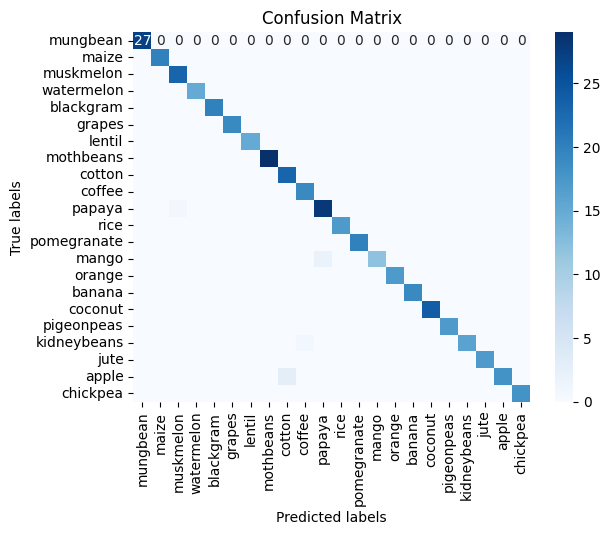

In [10]:
conf_matrix = confusion_matrix(test_labels, test_predict)
sns.heatmap(
        conf_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        xticklabels=test_labels.unique(),
        yticklabels=test_labels.unique()
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 2.
#### Transform to binary labels
1. We want to change the labels of our dataset such that instead of it being from a list of crops it indicates whether or not the list is rice or not rice. 
2. Rice = 1, non-rice = 0

In [11]:
df_rice_recommend = df_crop_recommend.copy()

# Apply a function that returns 1 if the label is rice or 0 if not
df_rice_recommend['label'] = df_rice_recommend['label'].apply(
        lambda x: 1 if x == 'rice' else 0
)

df_rice_recommend.head(n=5)

,N,P,K,temperature,humidity,ph,rainfall,label
0,0.837945,-0.225,0.379310,-0.814696,0.051525,0.081874,1.809703,1
1,0.758893,0.175,0.310345,-0.660920,-0.005171,0.643995,2.206918,1
2,0.363636,0.100,0.413793,-0.447878,0.062237,1.486593,2.831689,1
3,0.584980,-0.400,0.275862,0.154068,-0.010603,0.583388,2.478345,1
4,0.648221,-0.225,0.344828,-0.944105,0.038122,1.264171,2.810808,1


#### Train-Test Split 80-20
1. We split our data again because we are working with a copy

In [12]:
train_features, test_features, train_labels, test_labels = train_test_split(
        df_rice_recommend.drop(columns=["label"]),
        df_rice_recommend["label"], 
        test_size=0.2, 
        random_state=6
)

print("train_features:\n", train_features.head(n=1))
print("test_features:\n", test_features.head(n=1))
print("train_labels:\n", train_labels.head(n=5))
print("test_labels:\n", test_labels.head(n=5))

train_features:
              N     P         K  temperature  humidity       ph  rainfall
2071  0.980237  0.15  0.206897     -0.13681  0.054559 -0.07222  1.029777
test_features:
             N      P        K  temperature  humidity        ph  rainfall
614 -0.252964 -0.325 -0.37931     0.717627  0.201395  0.223365 -0.959906
train_labels:
 2071    0
140     0
50      1
216     0
1892    0
Name: label, dtype: int64
test_labels:
 614     0
162     0
1455    0
1388    0
732     0
Name: label, dtype: int64


#### Train Logistic Regression classifier

In [13]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(train_features, train_labels)

LogisticRegression()

#### Calculate the ROC curve

In [14]:
from sklearn.metrics import roc_curve, auc

# Get the probability values for the positive rice class
positive_probability = lr_model.predict_proba(test_features)[:, 1]

fpr, tpr, thresholds = roc_curve(test_labels, positive_probability)

roc_auc = auc(fpr, tpr)



#### Plot the ROC curve
1. When plotting the ROC curve we find that the curve is nearly completely optimal because it is in the upper left of the graph. 

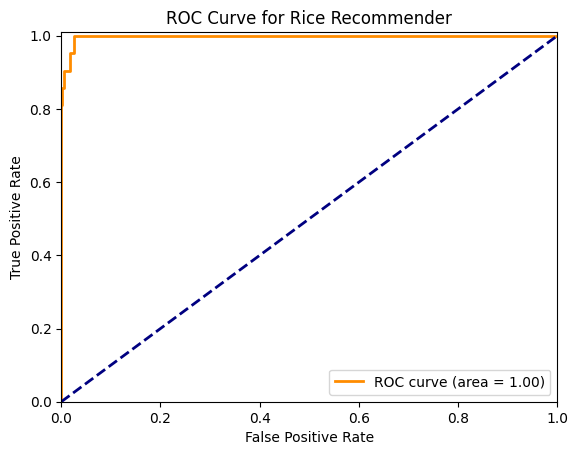

In [15]:
plt.figure()

# ROC Curve line
plt.plot(
        fpr, tpr, 
        color='darkorange',
        lw=2, 
        label=f'ROC curve (area = {roc_auc:.2f})'
)

# Center line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01]) # 1.01 so we don't hide the top of our curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Rice Recommender')
plt.legend(loc="lower right")
plt.show()


### 3.
#### SMS Text Classification

##### Read in the data
1. We can treat the file as a CSV with tabs as separators instead of commas 
2. We manually pass column labels because there is no header row. 

In [16]:
df_sms = pd.read_csv("SMSSpamCollection", sep="\t", names=["ham_or_spam", "text"])
print(df_sms.head(n=5))

df_sms.columns

  ham_or_spam                                               text
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...


Index(['ham_or_spam', 'text'], dtype='object')

##### Preprocess Data
1. Convert all the ham/spam to 0 and 1
   1. 0 is ham 1 is spam
2. Convert the text data into term frequency-inverse document frequency vectors.
   1. We can use sklearn's libraries to achieve this. 

In [17]:
def ham_spam_to_bin(ham_or_spam):
        if ham_or_spam == 'ham':
                return 0
        elif ham_or_spam == 'spam':
                return 1
        return ham_or_spam

df_sms['ham_or_spam'] = df_sms['ham_or_spam'].apply(
        lambda x: ham_spam_to_bin(x)
)

df_sms.head(n=20)

,ham_or_spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df_sms['text'])

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# print(df_tfidf)

df_sms = pd.concat([df_sms['ham_or_spam'], df_tfidf], axis=1)

df_sms.head(n=10)

,ham_or_spam,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Train Test Split

In [19]:


train_features, test_features, train_labels, test_labels = train_test_split(
        df_sms.drop(columns=["ham_or_spam"]),
        df_sms["ham_or_spam"], 
        test_size=0.2, 
        random_state=6
)

print("train_features:\n", train_features.head(n=1))
print("test_features:\n", test_features.head(n=1))
print("train_labels:\n", train_labels.head(n=5))
print("test_labels:\n", test_labels.head(n=5))

train_features:
        00  000  000pes  008704050406  0089  0121  01223585236  01223585334  \
1527  0.0  0.0     0.0           0.0   0.0   0.0          0.0          0.0   

      0125698789   02  ...  zhong  zindgi  zoe  zogtorius  zoom  zouk  zyada  \
1527         0.0  0.0  ...    0.0     0.0  0.0        0.0   0.0   0.0    0.0   

       èn   ú1  〨ud  
1527  0.0  0.0  0.0  

[1 rows x 8444 columns]
test_features:
        00  000  000pes  008704050406  0089  0121  01223585236  01223585334  \
2958  0.0  0.0     0.0           0.0   0.0   0.0          0.0          0.0   

      0125698789   02  ...  zhong  zindgi  zoe  zogtorius  zoom  zouk  zyada  \
2958         0.0  0.0  ...    0.0     0.0  0.0        0.0   0.0   0.0    0.0   

       èn   ú1  〨ud  
2958  0.0  0.0  0.0  

[1 rows x 8444 columns]
train_labels:
 1527    0
338     0
5032    0
2674    0
3250    0
Name: ham_or_spam, dtype: int64
test_labels:
 2958    0
2482    0
2745    0
3556    1
4509    0
Name: ham_or_spam, dtype: int64


##### Train SVC model
1. We will use a linear kernel
2. The fitting took around a minute

In [20]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(train_features, train_labels)

SVC(kernel='linear', probability=True)

##### Evaluate the SVC Model
1. Considering we have done very little postprocessing we got extremely good results in the test accuracy scores. 

In [21]:
predicted_labels = svc_model.predict(test_features)

print("Report SVC: \n", classification_report(test_labels, predicted_labels))

print("Confusion Matrix: \n", confusion_matrix(test_labels, predicted_labels))

Report SVC: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.92      0.96       135

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Confusion Matrix: 
 [[980   0]
 [ 11 124]]


##### Train Random Forest Classifier
1. We will try 100 estimators 
2. Increasing the estimator count ended up making performance worse

In [22]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=6)
random_forest_model.fit(train_features, train_labels)


RandomForestClassifier(random_state=6)

##### Evaluate Random Forest Classifier
1. Our testing accuracy ended up being a bit less than SVM
2. However the random forest classifier took much less time to train and evaluate. 

In [23]:
predicted_labels = random_forest_model.predict(test_features)

print("Report SVC: \n", classification_report(test_labels, predicted_labels))

print("Confusion Matrix: \n", confusion_matrix(test_labels, predicted_labels))

Report SVC: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.89      0.94       135

    accuracy                           0.99      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Confusion Matrix: 
 [[980   0]
 [ 15 120]]
